In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np



crossValidationDataPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Training/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Training/LeftHand_NO_FLIP']
testPaths=['NORMALIZED_ORIGINAL/NumericalData/ML/Test/RightHand','NORMALIZED_ORIGINAL/NumericalData/ML/Test/LeftHand_NO_FLIP']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    


test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 32
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-08 15:35:42.463958: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 15:35:42.485682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 15:35:42.485702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 15:35:42.486399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 15:35:42.490466: I tensorflow/core/platform/cpu_feature_guar

[25, 48, 28, 4, 51, 48, 15, 21, 35, 4, 55, 17, 50, 26, 52, 32, 34, 38, 59, 26, 13, 4, 20, 55, 32, 23, 24, 55, 21, 7, 22, 52, 18, 6, 2, 16, 2, 19, 16, 5, 21, 55, 13, 18, 59, 23, 1, 59, 55, 16, 40, 17, 30, 42, 51, 17, 53, 40, 44, 5, 39, 13, 0, 40, 49, 9, 6, 15, 24, 14, 24, 21, 56, 4, 51, 27, 56, 15, 29, 25, 51, 9, 24, 23, 0, 25, 15, 27, 1, 30, 23, 45, 28, 34, 36, 58, 39, 38, 21, 7, 6, 0, 23, 42, 31, 12, 38, 9, 58, 50, 1, 46, 55, 2, 28, 46, 24, 23, 36, 29, 2, 56, 33, 17, 10, 10, 57, 45, 5, 1, 56, 37, 12, 15, 15, 6, 55, 12, 26, 38, 56, 1, 22, 4, 56, 0, 58, 11, 2, 57, 48, 49, 0, 45, 14, 21, 58, 46, 19, 45, 57, 31, 58, 28, 47, 56, 19, 31, 54, 14, 56, 2, 49, 9, 4, 52, 55, 18, 7, 17, 36, 42, 19, 42, 12, 29, 58, 59, 9, 45, 5, 12, 41, 59, 11, 24, 37, 28, 3, 2, 25, 51, 37, 56, 53, 42, 1, 57, 20, 22, 23, 19, 36, 20, 16, 17, 6, 27, 44, 12, 17, 26, 32, 4, 18, 23, 46, 5, 57, 4, 49, 45, 7, 10, 5, 29, 55, 48, 22, 21, 36, 44, 57, 14, 17, 22, 20, 1, 19, 52, 36, 56, 55, 58, 32, 44, 24, 4, 12, 24, 34, 10, 

In [5]:


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
   
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2024-01-08 15:35:43.778950: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-08 15:35:43.778970: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-08 15:35:43.778973: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-08 15:35:43.779070: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-08 15:35:43.779079: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-08 15:35:43.779081: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704706547.267219 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8068 - accuracy: 0.0787

W0000 00:00:1704706556.344918 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.8061 - accuracy: 0.0790 - val_loss: 3.3635 - val_accuracy: 0.2090
Epoch 2/200
226/226 [==============================] - 8s 37ms/step - loss: 3.1399 - accuracy: 0.2190 - val_loss: 2.7390 - val_accuracy: 0.3905
Epoch 3/200
226/226 [==============================] - 8s 37ms/step - loss: 2.6423 - accuracy: 0.3358 - val_loss: 2.2998 - val_accuracy: 0.4813
Epoch 4/200
226/226 [==============================] - 8s 37ms/step - loss: 2.3294 - accuracy: 0.4100 - val_loss: 1.9899 - val_accuracy: 0.5634
Epoch 5/200
226/226 [==============================] - 8s 37ms/step - loss: 2.1079 - accuracy: 0.4620 - val_loss: 1.7560 - val_accuracy: 0.6132
Epoch 6/200
226/226 [==============================] - 8s 37ms/step - loss: 1.8936 - accuracy: 0.5156 - val_loss: 1.5535 - val_accuracy: 0.6692
Epoch 7/200
226/226 [==============================] - 8s 37ms/step - loss: 1.7217 - accuracy: 0.5597 - val_loss: 1.4253 - val_accuracy: 0.6928
Epo

W0000 00:00:1704707522.903303 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 1: 0.9788557213930348
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5775862068965517
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704707527.450992 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.6843 - accuracy: 0.1124

W0000 00:00:1704707536.584070 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.6824 - accuracy: 0.1125 - val_loss: 3.0975 - val_accuracy: 0.2740
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 2.9051 - accuracy: 0.2749 - val_loss: 2.3736 - val_accuracy: 0.4745
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.4644 - accuracy: 0.3885 - val_loss: 1.9866 - val_accuracy: 0.5803
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.1385 - accuracy: 0.4532 - val_loss: 1.6942 - val_accuracy: 0.6725
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 1.8837 - accuracy: 0.5160 - val_loss: 1.4964 - val_accuracy: 0.6936
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 1.6931 - accuracy: 0.5591 - val_loss: 1.2435 - val_accuracy: 0.7484
Epoch 7/200
226/226 [==============================] - 9s 38ms/step - loss: 1.5298 - accuracy: 0.6011 - val_loss: 1.1007 - val_accuracy: 0.7808
Epo

W0000 00:00:1704708144.032259 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 2: 0.975093399750934
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5815047021943573
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704708148.350729 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.6759 - accuracy: 0.1139

W0000 00:00:1704708157.480992 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 41ms/step - loss: 3.6740 - accuracy: 0.1144 - val_loss: 3.0730 - val_accuracy: 0.3300
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 2.9343 - accuracy: 0.2647 - val_loss: 2.4370 - val_accuracy: 0.4446
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.5124 - accuracy: 0.3553 - val_loss: 2.0445 - val_accuracy: 0.5392
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.1949 - accuracy: 0.4366 - val_loss: 1.7637 - val_accuracy: 0.6177
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 1.9692 - accuracy: 0.4878 - val_loss: 1.4820 - val_accuracy: 0.6949
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 1.7404 - accuracy: 0.5421 - val_loss: 1.3020 - val_accuracy: 0.7497
Epoch 7/200
226/226 [==============================] - 9s 38ms/step - loss: 1.5918 - accuracy: 0.5807 - val_loss: 1.1730 - val_accuracy: 0.7870
Epo

W0000 00:00:1704708907.618515 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 3: 0.9763387297633873
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5885579937304075
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704708911.947028 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.6903 - accuracy: 0.1103

W0000 00:00:1704708921.054781 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 41ms/step - loss: 3.6893 - accuracy: 0.1105 - val_loss: 3.1274 - val_accuracy: 0.2802
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 2.8975 - accuracy: 0.2712 - val_loss: 2.4366 - val_accuracy: 0.4396
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.4363 - accuracy: 0.3763 - val_loss: 2.0029 - val_accuracy: 0.5492
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.0945 - accuracy: 0.4622 - val_loss: 1.6872 - val_accuracy: 0.6326
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 1.8099 - accuracy: 0.5350 - val_loss: 1.4177 - val_accuracy: 0.6936
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 1.6139 - accuracy: 0.5833 - val_loss: 1.2437 - val_accuracy: 0.7347
Epoch 7/200
226/226 [==============================] - 9s 38ms/step - loss: 1.4678 - accuracy: 0.6122 - val_loss: 1.1350 - val_accuracy: 0.7659
Epo

W0000 00:00:1704709522.716614 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 4: 0.9713574097135741
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.579153605015674
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704709526.875566 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.7286 - accuracy: 0.0985

W0000 00:00:1704709536.007527 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.7281 - accuracy: 0.0984 - val_loss: 3.2083 - val_accuracy: 0.2690
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 3.0167 - accuracy: 0.2515 - val_loss: 2.5510 - val_accuracy: 0.4508
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.5996 - accuracy: 0.3445 - val_loss: 2.1913 - val_accuracy: 0.5367
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.3019 - accuracy: 0.4178 - val_loss: 1.8707 - val_accuracy: 0.6102
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 2.0515 - accuracy: 0.4744 - val_loss: 1.6275 - val_accuracy: 0.6550
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 1.8727 - accuracy: 0.5180 - val_loss: 1.5171 - val_accuracy: 0.6912
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.6847 - accuracy: 0.5567 - val_loss: 1.3096 - val_accuracy: 0.7248
Epo

W0000 00:00:1704710234.379607 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 5: 0.9726027397260274
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5846394984326019
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704710238.813663 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.7776 - accuracy: 0.0897

W0000 00:00:1704710247.967953 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.7772 - accuracy: 0.0895 - val_loss: 3.2758 - val_accuracy: 0.2192
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 3.0293 - accuracy: 0.2439 - val_loss: 2.5809 - val_accuracy: 0.4097
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.5596 - accuracy: 0.3499 - val_loss: 2.1490 - val_accuracy: 0.5342
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.2320 - accuracy: 0.4285 - val_loss: 1.8742 - val_accuracy: 0.5915
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9812 - accuracy: 0.4844 - val_loss: 1.6121 - val_accuracy: 0.6638
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 1.7594 - accuracy: 0.5422 - val_loss: 1.4439 - val_accuracy: 0.6912
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.6180 - accuracy: 0.5708 - val_loss: 1.3080 - val_accuracy: 0.7397
Epo

W0000 00:00:1704710947.952252 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 6: 0.9651307596513076
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5830721003134797
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704710952.131298 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.6640 - accuracy: 0.1139

W0000 00:00:1704710961.610472 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 43ms/step - loss: 3.6617 - accuracy: 0.1143 - val_loss: 3.1060 - val_accuracy: 0.2615
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 2.9227 - accuracy: 0.2600 - val_loss: 2.4570 - val_accuracy: 0.4222
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.4539 - accuracy: 0.3612 - val_loss: 2.0628 - val_accuracy: 0.5380
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1395 - accuracy: 0.4368 - val_loss: 1.6817 - val_accuracy: 0.6202
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 1.8679 - accuracy: 0.5100 - val_loss: 1.4490 - val_accuracy: 0.7011
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 1.6632 - accuracy: 0.5571 - val_loss: 1.2479 - val_accuracy: 0.7472
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.5023 - accuracy: 0.5975 - val_loss: 1.1276 - val_accuracy: 0.7684
Epo

W0000 00:00:1704711970.962501 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 7: 0.9813200498132005
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5940438871473355
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704711975.137527 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.6765 - accuracy: 0.1096

W0000 00:00:1704711984.276140 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.6748 - accuracy: 0.1096 - val_loss: 3.0920 - val_accuracy: 0.3225
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 2.8992 - accuracy: 0.2644 - val_loss: 2.5213 - val_accuracy: 0.4359
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.4618 - accuracy: 0.3637 - val_loss: 2.1111 - val_accuracy: 0.5255
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1638 - accuracy: 0.4377 - val_loss: 1.8359 - val_accuracy: 0.5803
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9396 - accuracy: 0.4877 - val_loss: 1.6547 - val_accuracy: 0.6413
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 1.7607 - accuracy: 0.5361 - val_loss: 1.4361 - val_accuracy: 0.6725
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.5905 - accuracy: 0.5818 - val_loss: 1.2591 - val_accuracy: 0.7298
Epo

W0000 00:00:1704712561.950281 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 8: 0.9738480697384807
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6003134796238244
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704712566.361428 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8879 - accuracy: 0.0683

W0000 00:00:1704712575.538176 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.8867 - accuracy: 0.0685 - val_loss: 3.5038 - val_accuracy: 0.1793
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.3253 - accuracy: 0.1926 - val_loss: 2.9429 - val_accuracy: 0.3325
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.8619 - accuracy: 0.2908 - val_loss: 2.5018 - val_accuracy: 0.4421
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.5493 - accuracy: 0.3618 - val_loss: 2.2424 - val_accuracy: 0.5330
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.2946 - accuracy: 0.4249 - val_loss: 1.9987 - val_accuracy: 0.6227
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.0650 - accuracy: 0.4763 - val_loss: 1.7603 - val_accuracy: 0.6376
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9089 - accuracy: 0.5163 - val_loss: 1.5935 - val_accuracy: 0.6862
Epo

W0000 00:00:1704713517.142916 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 9: 0.9800747198007472
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6010971786833855
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704713521.323006 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.6380 - accuracy: 0.1110

W0000 00:00:1704713530.525436 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.6365 - accuracy: 0.1114 - val_loss: 3.0455 - val_accuracy: 0.2503
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 2.9028 - accuracy: 0.2579 - val_loss: 2.4633 - val_accuracy: 0.4558
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.4760 - accuracy: 0.3619 - val_loss: 2.0557 - val_accuracy: 0.5567
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1788 - accuracy: 0.4358 - val_loss: 1.7704 - val_accuracy: 0.6252
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9387 - accuracy: 0.5018 - val_loss: 1.5358 - val_accuracy: 0.6862
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 1.7572 - accuracy: 0.5403 - val_loss: 1.3203 - val_accuracy: 0.7360
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.6084 - accuracy: 0.5753 - val_loss: 1.2102 - val_accuracy: 0.7597
Epo

W0000 00:00:1704714315.314764 1279182 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 10: 0.9663760896637609
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6136363636363636
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.5775862068965517, 0.5815047021943573, 0.5885579937304075, 0.579153605015674, 0.5846394984326019, 0.5830721003134797, 0.5940438871473355, 0.6003134796238244, 0.6010971786833855, 0.6136363636363636]
0.590360501567398
[0.9788557213930348, 0.975093399750934, 0.9763387297633873, 0.9713574097135741, 0.9726027397260274, 0.9651307596513076, 0.9813200498132005, 0.9738480697384807, 0.9800747198007472, 0.9663760896637609]
0.9740997689014455


test accuracies:  [0.5775862068965517, 0.5815047021943573, 0.5885579937304075, 0.579153605015674, 0.5846394984326019, 0.5830721003134797, 0.5940438871473355, 0.6003134796238244, 0.6010971786833855, 0.6136363636363636] 9
validation accuracies:  [0.9788557213930348, 0.975093399750934, 0.9763387297633873, 0.9713574097135741, 0.9726027397260274, 0.9651307596513076, 0.9813200498132005, 0.9738480697384807, 0.9800747198007472, 0.9663760896637609]
60


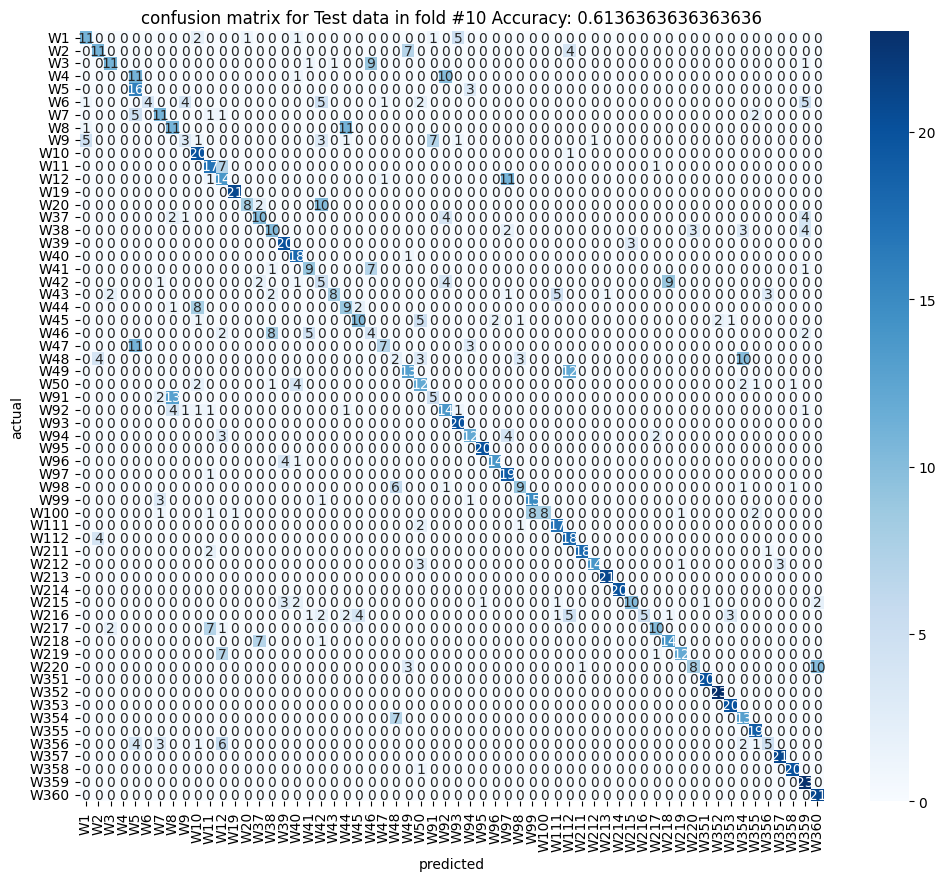

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

